In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
def cleaning_data(df):
    #df=df.reset_index()
    #casting date field to datetime format to utilise .dt.month attribute
    df['dt'] = pd.to_datetime(df['dt'])
    #creating a dictionary of the fields with null values
    dictionary = (df.isna().any()==True).to_dict()
    
    #iterating through the dictionary to find where True
    for col,val in dictionary.items():
        if val == True:                  
            #creating a dataframe of the null values
            null_df = df[df.isna()[col]==True]

            for i in null_df.index:
                month = df.loc[i,'dt'].to_pydatetime().month
                mean = df[df["dt"].dt.month == month].dropna()[col].mean()
                df.at[i,col]=mean

In [4]:
dataset2 = pd.read_csv('GlobalLandTemperaturesByCountry.csv',index_col=['dt'])
dataFrame2 =pd.DataFrame(dataset2)
dataFrame2=dataFrame2.reset_index()
greenLandTemp = dataFrame2[dataFrame2['Country']=='Greenland']

In [5]:
cleaning_data(greenLandTemp)

In [6]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import requests
from bs4 import BeautifulSoup
url = 'https://masie_web.apps.nsidc.org/pub//DATASETS/NOAA/G02135/seaice_analysis/'
r = requests.get(url)
html_doc = r.text
soup = BeautifulSoup(html_doc)


for file in soup.find_all('a'):
    print(file.get('href'))



?C=N;O=D
?C=M;O=A
?C=S;O=A
?C=D;O=A
/pub/DATASETS/NOAA/G02135/
Arctic_region_mask_Meier_AnnGlaciol2007.msk
Arctic_region_mask_Meier_AnnGlaciol2007.txt
N_Sea_Ice_Index_Regional_Daily_Data_G02135_v3.0.xlsx
N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx
S_Sea_Ice_Index_Regional_Daily_Data_G02135_v3.0.xlsx
S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx
Sea_Ice_Index_Daily_Extent_G02135_v3.0.xlsx
Sea_Ice_Index_Min_Max_Rankings_G02135_v3.0.xlsx
Sea_Ice_Index_Monthly_Data_by_Year_G02135_v3.0.xlsx
Sea_Ice_Index_Monthly_Data_with_Statistics_G02135_v3.0.xlsx
Sea_Ice_Index_Rates_of_Change_G02135_v3.0.xlsx


In [7]:
url = 'https://masie_web.apps.nsidc.org/pub//DATASETS/NOAA/G02135/seaice_analysis/N_Sea_Ice_Index_Regional_Daily_Data_G02135_v3.0.xlsx'
file = pd.read_excel(url,sheet_name=None)
#xls = pd.ExcelFile(file)

In [8]:
file2 = pd.read_excel(url,sheet_name=1)
dataframeSI = pd.DataFrame(file2)
dataframeSI['month']=dataframeSI['month'].fillna(method='ffill')
look_up = {'January':'01', 'February':'02', 'March':'03', 'April':'04', 'May':'05',
           'June':'06','July':'07', 'August':'08', 'September':'09', 'October':'10',
           'November':'11', 'December':'12'}

dataframeSI['month'] = dataframeSI['month'].apply(lambda x: look_up[x])

In [9]:
col_list = dataframeSI.keys()[2:]
i = 0
for col in col_list:
    df = dataframeSI[['month','day',col]]
    df = df.rename(columns = {col:"Extent"})
    df['Year'] = str(col)
    if i==0:
        df_corrected = df
    else:
        df_corrected= pd.concat([df_corrected,df],ignore_index=True,sort=True)
    i+=1
  

In [10]:
df_corrected=df_corrected.dropna()
df_corrected['Date']=pd.to_datetime(df_corrected[['Year', 'month', 'day']])

In [11]:
greenLandTemp=greenLandTemp.set_index('dt')
greenLandTemp=greenLandTemp['1979-01-01':'2013-09-01']
greenLandTemp=greenLandTemp.reset_index()

In [12]:
def plot_Temp_Data(month):
    
    #month = int(input('please enter the month (1-12) you would like to analyse (i.e Jan=1,Feb=2 etc.):'))  
    monthly_data = df_corrected[df_corrected['Date'].dt.month == month]
    monthly_mean = monthly_data.groupby('Year',as_index=False)['Extent'].agg('mean')
    monthly_mean = monthly_mean.merge(monthly_data[monthly_data['day']==1][['Year','Date']],how='right',left_on='Year',right_on='Year')
    
    fig,ax = plt.subplots(figsize=(12,8))
    monthly_mean = monthly_mean.set_index('Date')['1979-07-01':'2013-07-01'].reset_index()
    x_data_mean = monthly_mean['Date']
    y_data_mean = monthly_mean['Extent']
    
    ax.plot(x_data_mean,y_data_mean,color='r',marker='v',linestyle='-')
    
    monthly_Temp = greenLandTemp[greenLandTemp['dt'].dt.month == month]
    y_temp = monthly_Temp['AverageTemperature']
    x_temp = monthly_Temp['dt']
           
    ax2 = ax.twinx()
    ax2.plot(x_temp,y_temp,color='g',marker='o',linestyle='--')
    ax2.set_ylabel('Average Temperature (Celcius)',color='g')
    
    month_val = {1:'January', 2:'February', 3:'March', 4:'April', 5:'May',
               6:'June',7:'July', 8:'August', 9:'September', 10:'October',
               11:'November', 12:'December'}
    
    month= month_val.get(month)
    
    ax.set_xlabel('Date (years)')
    ax.set_ylabel('Sea Ice Extent (km^2)',color='r')
    ax.set_title('Sea Ice extent vs Temperature for %s' %month)
    ax.tick_params('y')
    ax.tick_params('x',colors='blue')
    plt.grid(True)
    plt.show()   

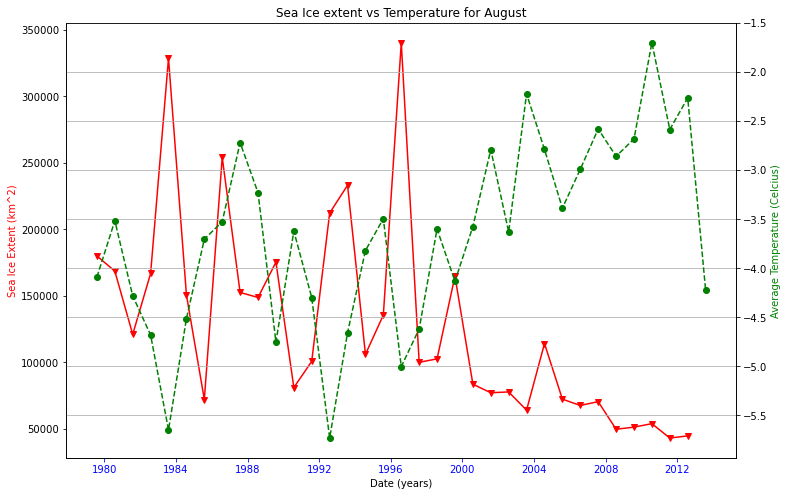

In [13]:
plot_Temp_Data(8)

In [53]:
import seaborn as sns

for index,rows in df_corrected.iterrows():
    df_corrected['Year'][index] = int(rows['Year'])

In [54]:
#Selecting out sea ice extent for summer months
df_Summer=df_corrected[(df_corrected['Year']>1980) 
                       &(df_corrected['Year']<2015)
                       & (df_corrected['month'].isin(['06','07','08']))]


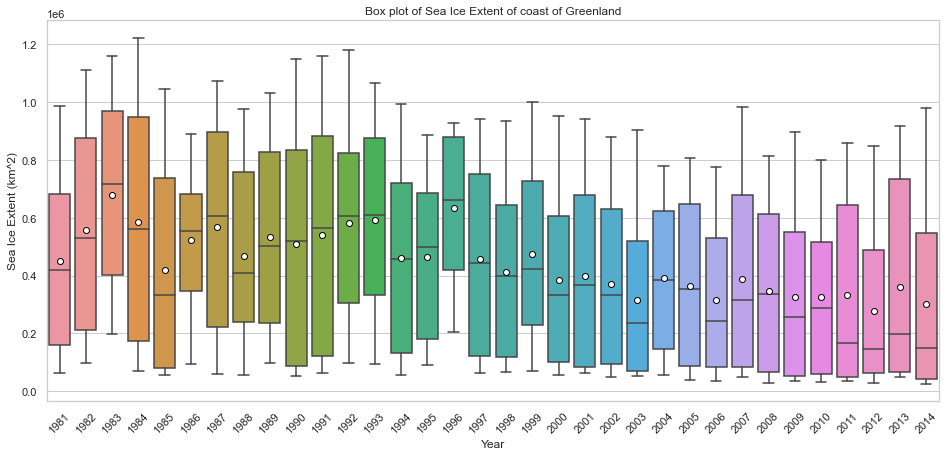

In [85]:
fig, ax = plt.subplots(figsize=(16,7))
sns.set_theme(style="whitegrid")
sns.boxplot(x="Year", y="Extent", data=df_Summer,showmeans=True, 
                     meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"6"})

plt.xticks(rotation=45);
ax.set_ylabel('Sea Ice Extent (km^2)')
ax.set_title('Box plot of Sea Ice Extent of coast of Greenland');
plt.show()
#line in the middle outlines the median
#whiskers outline the max and min values
#box part outlines the interquartile range

(200000.0, 700000.0)

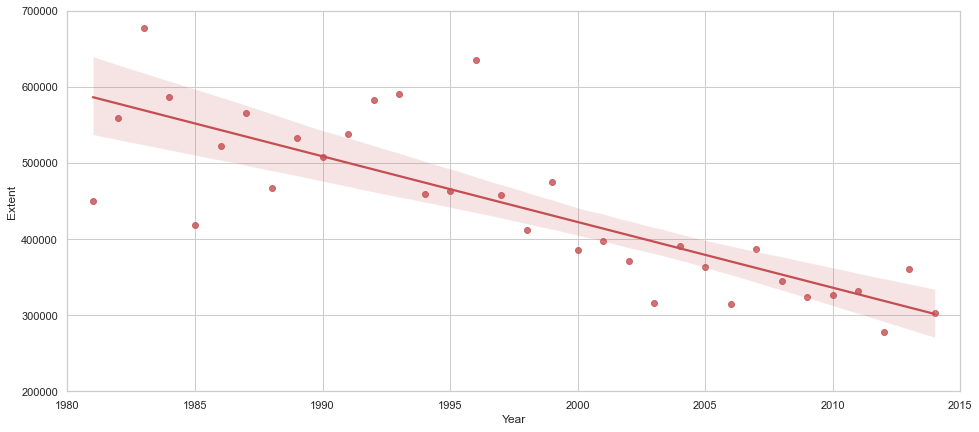

In [94]:
means=df_Summer.groupby('Year')['Extent'].mean().reset_index()
fig, ax = plt.subplots(figsize=(16,7))
sns.regplot(x=means['Year'],y=means['Extent'],data=means,color='r')
ax.set_xlim(1980,2015)
ax.set_ylim(200000,700000)